<a href="https://colab.research.google.com/github/mertakcay/ImageSimilarity/blob/main/ImageSimilarityTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wandb
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.1 MB/s 
     |████████████████████████████████| 181 kB 84.2 MB/s 
     |████████████████████████████████| 145 kB 73.6 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=3891a60603912a14c32c507eca5b9f0e6ef9ad750e78393d8a5f8042c2790bc9
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torchvision.transforms as T
import torch.optim as optim

import os
import sys

from PIL import Image
import numpy as np

from tqdm.notebook import tqdm
import wandb
import torch

In [4]:
class FolderDataset(Dataset):

    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        image = image.resize((256,256))

        if self.transform is not None:
            tensor_image = self.transform(image)

        return tensor_image, tensor_image

In [20]:
class ConvEncoder(nn.Module):
    """
    A simple Convolutional Encoder Model
    """

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d((2, 2))

        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d((2, 2))

        self.conv4 = nn.Conv2d(64, 128, (3, 3), padding=(1, 1))
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d((2, 2))

        self.conv5 = nn.Conv2d(128, 256, (3, 3), padding=(1, 1))
        self.relu5 = nn.ReLU(inplace=True)
        self.maxpool5 = nn.MaxPool2d((2, 2))

    def forward(self, x):
        # Downscale the image with conv maxpool etc.
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)
        
        return x

In [6]:
class ConvDecoder(nn.Module):
    """
    A simple Convolutional Decoder Model
    """

    def __init__(self):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(256, 128, (2, 2), stride=(2, 2))
        self.relu1 = nn.ReLU(inplace=True)

        self.deconv2 = nn.ConvTranspose2d(128, 64, (2, 2), stride=(2, 2))
        self.relu2 = nn.ReLU(inplace=True)

        self.deconv3 = nn.ConvTranspose2d(64, 32, (2, 2), stride=(2, 2))
        self.relu3 = nn.ReLU(inplace=True)

        self.deconv4 = nn.ConvTranspose2d(32, 16, (2, 2), stride=(2, 2))
        self.relu4 = nn.ReLU(inplace=True)

        self.deconv5 = nn.ConvTranspose2d(16, 3, (2, 2), stride=(2, 2))
        self.relu5 = nn.ReLU(inplace=True)

    def forward(self, x):
         # Upscale the image with convtranspose etc.
        x = self.deconv1(x)
        x = self.relu1(x)

        x = self.deconv2(x)
        x = self.relu2(x)

        x = self.deconv3(x)
        x = self.relu3(x)

        x = self.deconv4(x)
        x = self.relu4(x)

        x = self.deconv5(x)
        x = self.relu5(x)
        return x

In [ ]:
def train_step(encoder, decoder, train_loader, loss_fn, optimizer, device):


    encoder.train()
    decoder.train()
    
    for train_img, target_img in tqdm(train_loader):

        train_img = train_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()

        enc_output = encoder(train_img)

        dec_output = decoder(enc_output)

        loss = loss_fn(dec_output, target_img)
   
        loss.backward()
    
        optimizer.step()
   
    return loss.item()

def val_step(encoder, decoder, val_loader, loss_fn, device):

    encoder.eval()
    decoder.eval()
    
    
    with torch.no_grad():
        for train_img, target_img in tqdm(val_loader):
    
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            
            enc_output = encoder(train_img)
        
            dec_output = decoder(enc_output)

           
            loss = loss_fn(dec_output, target_img)
  
    return loss.item()

In [ ]:
transforms = T.Compose([T.ToTensor()]) 

full_dataset = FolderDataset("/content/drive/MyDrive/train/Train", transforms) # Create folder dataset.


val_size = int(len(full_dataset)*0.2)
train_size = len(full_dataset)- int(len(full_dataset)*0.2)
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

args = {
  "learning_rate": 0.0015581782063727588,
  "epochs": 32,
  "batch_size_train": 32,
  "batch_size_val": 16,
  "optimizer":"Adam"
}

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args['batch_size_train'], shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args['batch_size_val'])

full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=args['batch_size_train'])


loss_fn = nn.MSELoss() 

encoder = ConvEncoder() 
decoder = ConvDecoder() 

device = "cuda"  # GPU device


encoder.to(device)
decoder.to(device)


autoencoder_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(autoencoder_params, lr=args['learning_rate'])

wandb.init(project="Image Similarity", entity="akcaymert",config=args)

wandb.watch(encoder)

for epoch in range(args['epochs']):
        train_loss = train_step(encoder, decoder, train_loader, loss_fn, optimizer, device=device)
          
          
          
        val_loss = val_step(encoder, decoder, val_loader, loss_fn, device=device)
        if epoch % 1 == 0:
          wandb.log({"Epoch": epoch + 1,        
            "Train Loss":train_loss ,        
            "Validation Loss":val_loss})

In [ ]:
torch.save(encoder.state_dict(), '/content/drive/MyDrive/FakeReview/ImageSimilarity.pth')



In [ ]:
def create_embedding(encoder, full_loader, embedding_dim, device):
    encoder.load_state_dict(torch.load('/content/drive/MyDrive/FakeReview/ImageSimilarity.pth'))
    encoder.eval()
   
    embedding = torch.randn(embedding_dim)
    print(embedding.size)
    
   
    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(full_loader):
            
            train_img = train_img.to(device)
            
            
            enc_output = encoder(train_img).cpu()
            
            embedding = torch.cat((embedding, enc_output), 0)
    
    
    return embedding

In [ ]:
  transforms = T.Compose([T.ToTensor()]) 

  full_dataset = FolderDataset("/content/drive/MyDrive/train/Train", transforms) # Create folder dataset.


  val_size = int(len(full_dataset)*0.2)
  train_size = len(full_dataset)- int(len(full_dataset)*0.2)
  train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16)

  full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=32)

In [ ]:
EMBEDDING_SHAPE = (1, 256, 8, 8) 
encoder = ConvEncoder().to("cuda")
embedding = create_embedding(encoder, full_loader, EMBEDDING_SHAPE, "cuda" )


numpy_embedding = embedding.cpu().detach().numpy()
num_images = numpy_embedding.shape[0]


flattened_embedding = numpy_embedding.reshape((num_images, -1))
np.save("/content/drive/MyDrive/FakeReview/embedding.npy", flattened_embedding)

<built-in method size of Tensor object at 0x7fdccd1debf0>


In [ ]:
np.save("/content/drive/MyDrive/FakeReview/embedding.npy", flattened_embedding)

In [11]:
from sklearn.neighbors import NearestNeighbors

In [57]:


image = Image.open("/content/drive/MyDrive/FakeReview/shopping.png").convert("RGB")
image = image.resize((256,256))   
image_tensor = T.ToTensor()(image)
image_tensor = image_tensor.unsqueeze(0)

encoder = ConvEncoder()
#encoder = torch.load("/content/drive/MyDrive/FakeReview/ImageSimilarity.pth")

encoder.load_state_dict(torch.load("/content/drive/MyDrive/FakeReview/ImageSimilarity.pth"))
    
with torch.no_grad():
  image_embedding = encoder(image_tensor).cpu().detach().numpy()
        
flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))
knn = NearestNeighbors(n_neighbors=9, metric="cosine")
knn.fit(np.load("/content/drive/MyDrive/FakeReview/embedding.npy"))

_, indices = knn.kneighbors(flattened_embedding)

indices_list = indices.tolist()


In [58]:
indices_list[0]

[2013, 1069, 2409, 2322, 2241, 2330, 2639, 2575, 2692]

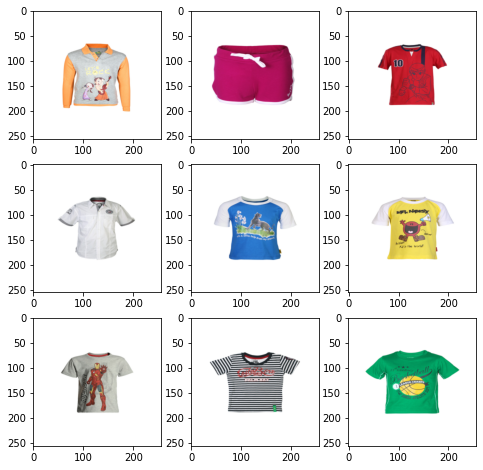

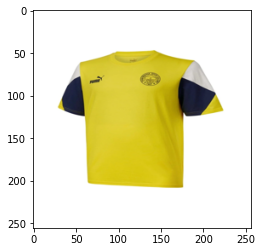

In [60]:
import matplotlib.pyplot as plt

transforms = T.Compose([T.ToTensor()]) 
full_dataset = FolderDataset("/content/drive/MyDrive/train/Train", transforms)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = indices_list[0][i-1]
    img, rawImage = full_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze().permute(1, 2, 0))
plt.show()


image = Image.open("/content/drive/MyDrive/FakeReview/shopping.png").convert("RGB")
image = image.resize((256,256))  

plt.imshow(image)